# **Praktikum D1 – Regresi dari Citra Sintetis (Prediksi Radius Lingkaran)**

##  Setup & Generator Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models

# Generator 1 sample
def make_sample(img_size=64, min_r=5, max_r=20):
  r = np.random.randint(min_r, max_r + 1) # radius acak
  img = np.zeros((img_size, img_size), dtype=np.uint8)
  cx = np.random.randint(r, img_size - r) # center-x
  cy = np.random.randint(r, img_size - r) # center-y
  cv2.circle(img, (cx, cy), r, (255,), -1) # lingkaran putih terisi
  img = (img / 255.0).astype(np.float32)
  # 3-channel biar kompatibel CNN
  img3 = np.stack([img, img, img], axis=-1)
  return img3, float(r), (cx, cy)


## “Tebak Apa?” — Tampilkan Contoh Gambar TANPA Label

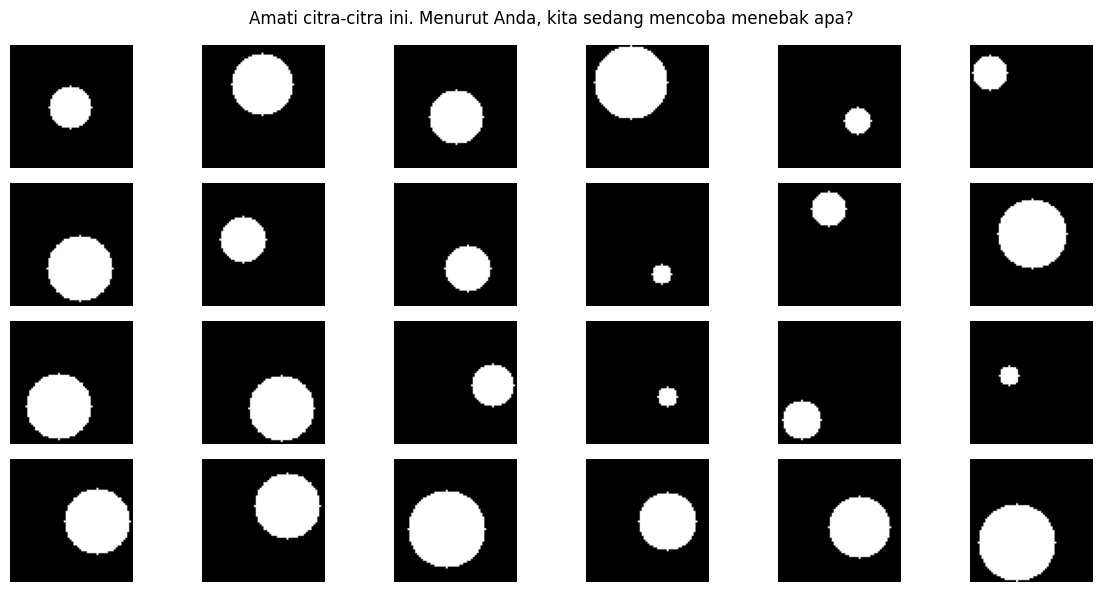

In [2]:
N_show = 24
samples = [make_sample() for _ in range(N_show)]
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]

cols = 6
rows = N_show // cols
plt.figure(figsize=(12, 6))
for i in range(N_show):
  plt.subplot(rows, cols, i+1)
  plt.imshow(imgs[i].squeeze(), cmap='gray')
  plt.axis('off')
plt.suptitle("Amati citra-citra ini. Menurut Anda, kita sedang mencoba menebak apa?")
plt.tight_layout()
plt.show()


##  Buka Jawaban — Target yang Ingin Diprediksi

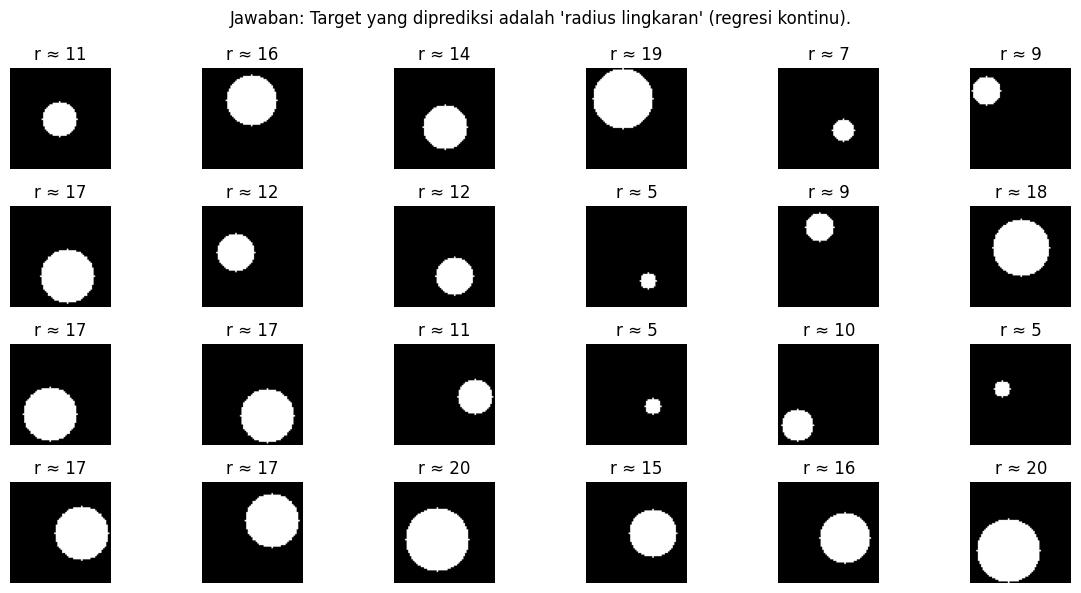

In [3]:
plt.figure(figsize=(12, 6))
for i in range(N_show):
  plt.subplot(rows, cols, i+1)
  plt.imshow(imgs[i].squeeze(), cmap='gray')
  plt.title(f"r ≈ {int(rads[i])}")
  plt.axis('off')
plt.suptitle("Jawaban: Target yang diprediksi adalah 'radius lingkaran' (regresi kontinu).")
plt.tight_layout()
plt.show()


## (Opsional) Latih CNN Kecil untuk Memprediksi Radius

In [4]:
# Dataset lebih besar untuk training
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Model CNN sederhana
model = models.Sequential([
  layers.Input((64,64,3)),
  layers.Conv2D(32, 3, activation='relu'), layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'), layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.GlobalAveragePooling2D(),
  layers.Dense(64, activation='relu'),
  layers.Dense(1) # output regresi
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(Xtr, ytr, validation_data=(Xte, yte), epochs=12, batch_size=64, verbose=0)

# Evaluasi
y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred)**2)))
r2 = r2_score(yte, y_pred)
print(f"MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
MAE=0.955 | RMSE=1.174 | R²=0.937


## Plot history & True vs Predicted

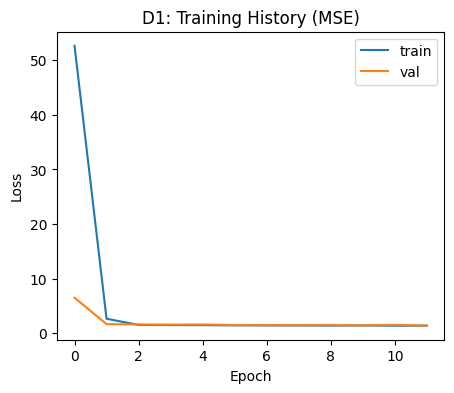

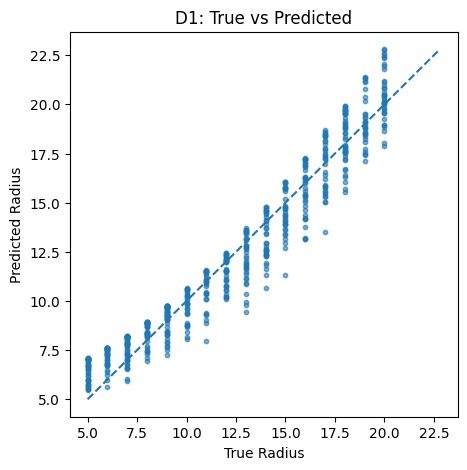

In [5]:
# Plot loss
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("D1: Training History (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

# Scatter True vs Pred
plt.figure(figsize=(5,5))
plt.scatter(yte, y_pred, s=10, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, '--')
plt.xlabel("True Radius"); plt.ylabel("Predicted Radius")
plt.title("D1: True vs Predicted")
plt.show()

# **Praktikum D2 – Menebak Umur Manusia dari Foto Wajah (UTKFace)**

## Mengunggah kaggle.json ke Colab

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"giilar30","key":"7e2c5e96574f57da3a4629f4c8112ce0"}'}

In [3]:
import os, shutil
if os.path.exists("kaggle.json"):
  os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
  shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
  os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
  !pip -q install kaggle
  print("✅ Kaggle API siap digunakan.")
else:
  print(" kaggle.json belum ditemukan. Upload terlebih dahulu.")

✅ Kaggle API siap digunakan.


## Mengunduh Dataset UTKFace dari Kaggle

In [4]:
# Unduh dataset UTKFace (sekali saja)
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print("✅ Dataset UTKFace berhasil diekstrak.")

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
✅ Dataset UTKFace berhasil diekstrak.


## Menampilkan Contoh Gambar Dataset

Total gambar ditemukan: 23708


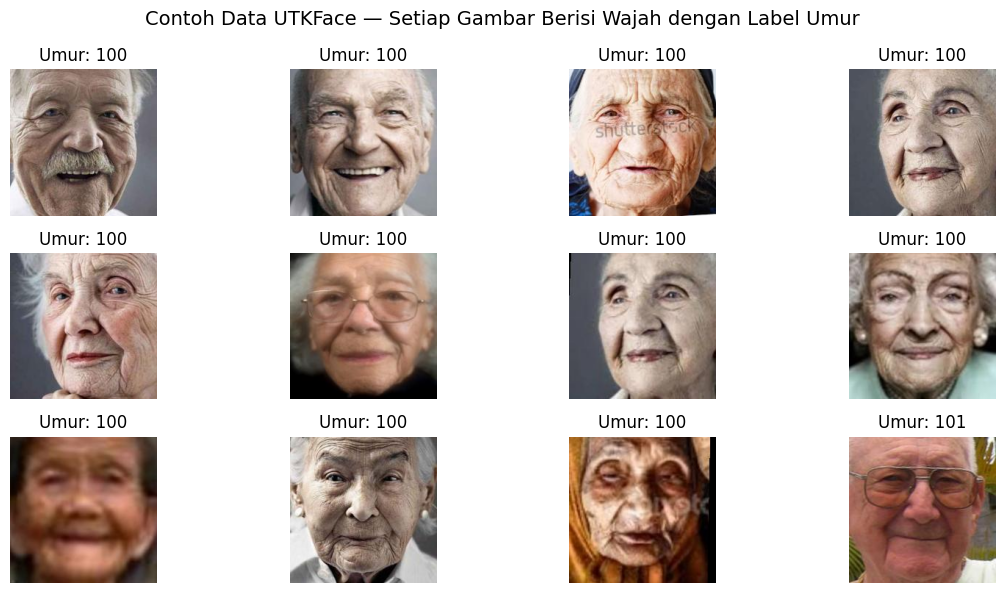

In [5]:
import matplotlib.pyplot as plt
import os, glob
from PIL import Image
# Ambil 12 gambar acak dari dataset
files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")

plt.figure(figsize=(12, 6))

for i, f in enumerate(files[:12]):
  # Ambil umur dari nama file
  age = int(os.path.basename(f).split("_")[0])
  img = Image.open(f)
  plt.subplot(3, 4, i + 1)
  plt.imshow(img)
  plt.title(f"Umur: {age}")
  plt.axis("off")
plt.suptitle("Contoh Data UTKFace — Setiap Gambar Berisi Wajah dengan Label Umur", fontsize=14)
plt.tight_layout()
plt.show()

## Siapkan Dataset untuk Model

In [6]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

def parse_age_from_name(fp):
  return int(os.path.basename(fp).split('_')[0])

ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)
train_files, test_files, y_train, y_test = train_test_split(
  files, ages, test_size=0.2, random_state=42
)

IMG_SIZE = 160

def load_img(fp, label):
  img = tf.io.read_file(fp)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
  return img / 255.0, label

train_ds = tf.data.Dataset.from_tensor_slices((train_files, y_train)).map(load_img).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_files, y_test)).map(load_img).batch(64)
print("✅ Dataset siap dilatih.")

✅ Dataset siap dilatih.


## Membangun Model dengan Transfer Learning

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Gunakan GPU jika tersedia
print("Hardware:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

# Buat arsitektur model
base_model = tf.keras.applications.MobileNetV2(
  include_top=False,
  input_shape=(IMG_SIZE, IMG_SIZE, 3),
  weights='imagenet'
)

base_model.trainable = False # tahap awal: freeze backbone

# Tambahkan head regresi
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x) # output tunggal: umur
model = tf.keras.Model(inputs, outputs)

# Kompilasi model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse', metrics=['mae'])
model.summary()

Hardware: GPU
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Melatih Model (Tahap 1 – Frozen)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 63s 126ms/step - loss: 364.1668 - mae: 14.0265 - val_loss: 162.2080 - val_mae: 9.6958 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 156.6163 - mae: 9.3229 - val_loss: 148.7110 - val_mae: 9.1696 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - loss: 145.5677 - mae: 8.9117 - val_loss: 141.7793 - val_mae: 8.8817 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - loss: 140.6726 - mae: 8.7339 - val_loss: 142.3539 - val_mae: 8.9228 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 139.2320 - mae: 8.6511 - val_loss: 137.2186 - val_mae: 8.6372 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 137.7965 - mae: 8.6143 - val_loss: 136.9648 - val_mae: 8.6725 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 134.6859 - mae: 8.5252 - val_loss: 135.2643 - va

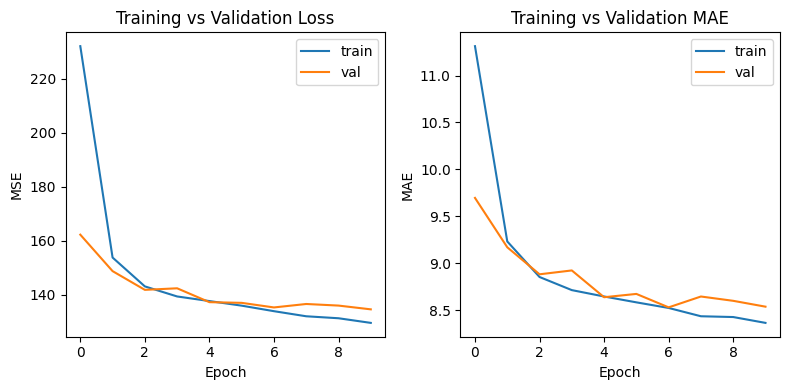

In [8]:
# Callback untuk pelatihan yang lebih stabil
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e5, monitor='val_loss')
]

history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=10,
  callbacks=cb,
  verbose=1
)

# Visualisasi perubahan loss dan MAE:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('Training vs Validation Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()
plt.tight_layout()
plt.show()


## Fine-tuning Backbone (Tahap 2)

Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 46s 100ms/step - loss: 190.4920 - mae: 10.1869 - val_loss: 162.6711 - val_mae: 9.4817 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 77.0501 - mae: 6.4686 - val_loss: 180.4943 - val_mae: 10.3522 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 52.0378 - mae: 5.3973 - val_loss: 142.2086 - val_mae: 8.9876 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 38.4805 - mae: 4.6610 - val_loss: 104.3997 - val_mae: 7.4150 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - loss: 29.7574 - mae: 4.1152 - val_loss: 110.5232 - val_mae: 7.5228 - learning_rate: 1.0000e-04


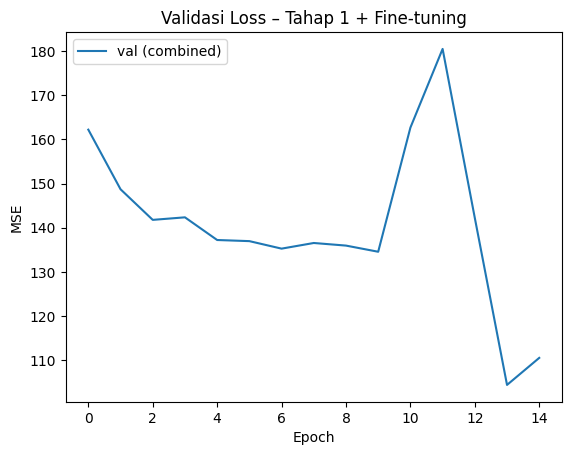

In [9]:
# Aktifkan kembali sebagian layer terakhir untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
  layer.trainable = False # beku sebagian besar layer

# Recompile dengan learning rate lebih kecil
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse', metrics=['mae'])

history_ft = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=5,
  callbacks=cb,
  verbose=1
)

# Visualisasi gabungan training dan fine-tuning:
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'],
label='val (combined)')
plt.title("Validasi Loss – Tahap 1 + Fine-tuning")
plt.xlabel("Epoch"); plt.ylabel("MSE")
plt.legend()
plt.show()

## Evaluasi Akhir (MAE, RMSE, R²)

MAE = 7.41 tahun
RMSE = 10.22 tahun
R² = 0.737


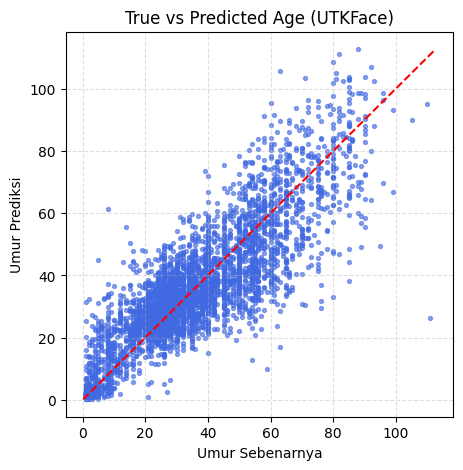

In [10]:
from math import sqrt

y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for
batch in test_ds])
mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred)**2))
r2 = r2_score(y_test, y_pred)
print(f"MAE = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R² = {r2:.3f}")

# Plot “umur sebenarnya vs umur prediksi”:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color='royalblue')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("Umur Sebenarnya")
plt.ylabel("Umur Prediksi")
plt.title("True vs Predicted Age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

## Melihat Contoh Prediksi Nyata


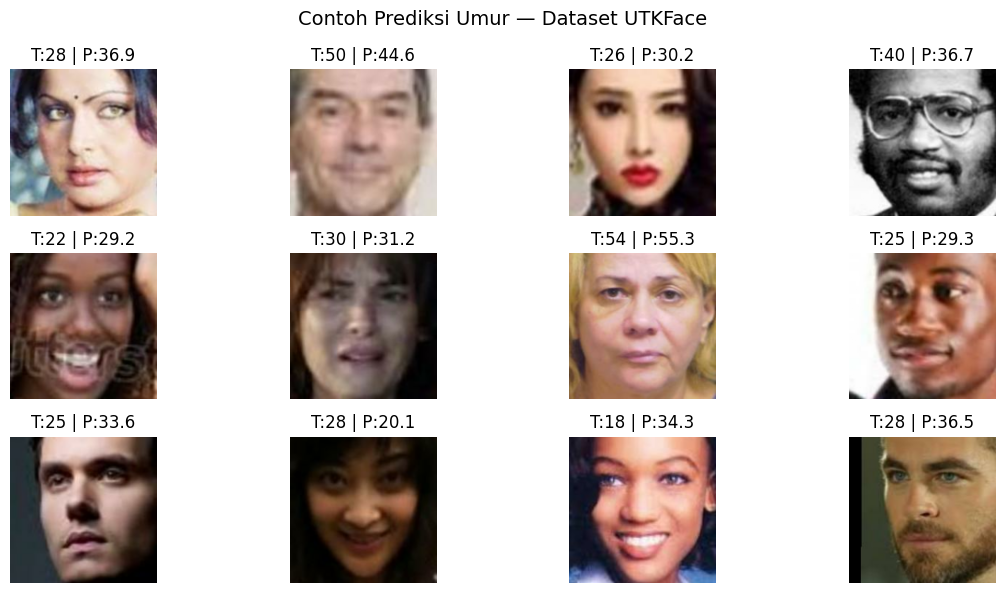

In [11]:
import random

sample_paths = random.sample(test_files, 12)
plt.figure(figsize=(12,6))

for i, path in enumerate(sample_paths):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
  true_age = int(os.path.basename(path).split('_')[0])
  pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]
  plt.subplot(3,4,i+1)
  plt.imshow(img.numpy())
  plt.title(f"T:{true_age} | P:{pred_age:.1f}")
  plt.axis('off')
plt.suptitle("Contoh Prediksi Umur — Dataset UTKFace", fontsize=14)
plt.tight_layout()
plt.show()

## Memprediksi dari foto upload

Saving WhatsApp Image 2025-10-09 at 12.01.32_7a8985e0.jpg to WhatsApp Image 2025-10-09 at 12.01.32_7a8985e0 (1).jpg


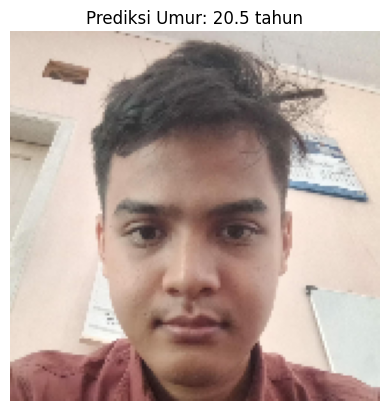

In [12]:
from google.colab import files
import tensorflow as tf
import matplotlib.pyplot as plt

uploaded = files.upload()

for filename in uploaded.keys():
    img_path = filename
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0

    pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]

    plt.imshow(img.numpy())
    plt.title(f"Prediksi Umur: {pred_age:.1f} tahun")
    plt.axis("off")
    plt.show()


# **Praktikum D3 — Menilai “Kepopuleran Hewan Peliharaan” dari Foto**

## Menyiapkan Kaggle API

*uncomment jika belum diupload*

In [16]:
from google.colab import files
files.upload()

{}

In [13]:
import os, shutil
if os.path.exists("kaggle.json"):
  os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
  shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
  os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
  !pip -q install kaggle
  print("✅ Kaggle API siap digunakan.")
else:
  print(" kaggle.json belum ditemukan. Upload terlebih dahulu.")

✅ Kaggle API siap digunakan.


## Mengunduh dan Mengekstrak Dataset

In [14]:
# Unduh dataset Pawpularity (sekitar 800MB)
!kaggle competitions download -c petfinder-pawpularity-score -p /content -q
!unzip -q /content/petfinder-pawpularity-score.zip -d /content/paw
print("✅ Dataset Pawpularity berhasil diekstrak.")

✅ Dataset Pawpularity berhasil diekstrak.


## Melihat Contoh Data

                                 Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                                path  
0  /content/p

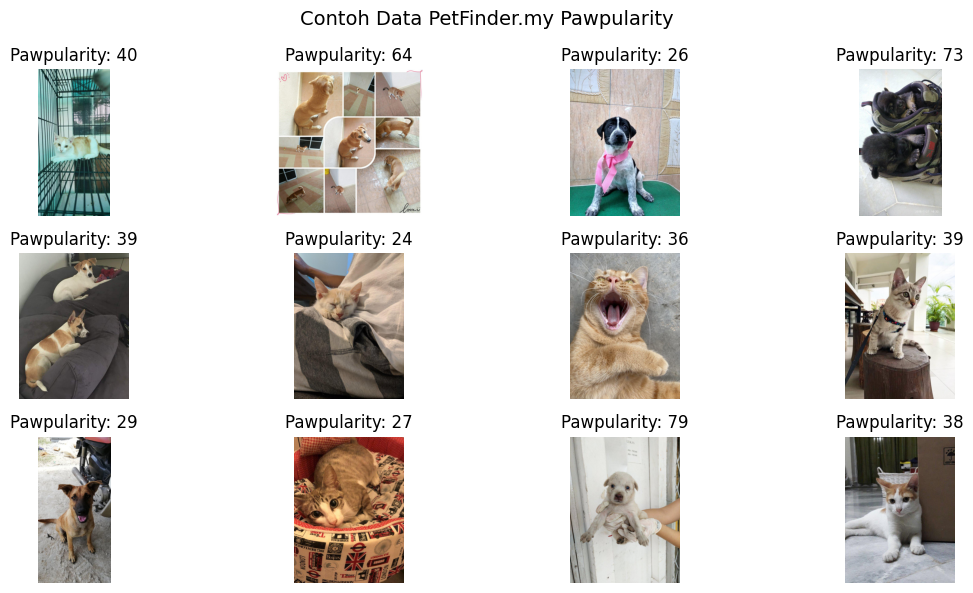

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

# Muat CSV
df = pd.read_csv('/content/paw/train.csv')
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")
print(df.head())

# Tampilkan 12 contoh gambar
plt.figure(figsize=(12, 6))
for i, row in enumerate(df.sample(12, random_state=42).itertuples()):
  img = Image.open(row.path)
  plt.subplot(3, 4, i + 1)
  plt.imshow(img)
  plt.title(f"Pawpularity: {row.Pawpularity}")
  plt.axis('off')
plt.suptitle("Contoh Data PetFinder.my Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()

## Persiapan Dataset

In [16]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

IMG_SIZE = 224
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

def load_image(path, label):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
  img = tf.cast(img, tf.float32) / 255.0
  return img, tf.cast(label, tf.float32)

train_ds = tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['Pawpularity']))\
.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
.shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((val_df['path'],
val_df['Pawpularity']))\
.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
.batch(64).prefetch(tf.data.AUTOTUNE)

print(f"Dataset siap digunakan — {len(train_df)} untuk training, {len(val_df)} untuk validasi.")

Dataset siap digunakan — 7929 untuk training, 1983 untuk validasi.


## Membangun Model (EfficientNetB0)

In [17]:
from tensorflow.keras import layers, models
base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base.trainable = False # freeze sementara
inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_1 (Multiply)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Melatih Model

In [18]:
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=cb, verbose=1)

Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 118s 540ms/step - loss: 775.4656 - mae: 20.9669 - val_loss: 468.2149 - val_mae: 15.9434 - learning_rate: 0.0010
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 42s 232ms/step - loss: 424.3344 - mae: 15.2782 - val_loss: 426.9464 - val_mae: 15.4023 - learning_rate: 0.0010
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 37s 200ms/step - loss: 395.5533 - mae: 14.7742 - val_loss: 405.6109 - val_mae: 15.0083 - learning_rate: 0.0010
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 44s 225ms/step - loss: 361.7785 - mae: 14.1163 - val_loss: 389.1200 - val_mae: 14.5331 - learning_rate: 0.0010
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 37s 187ms/step - loss: 371.3180 - mae: 14.3767 - val_loss: 383.5102 - val_mae: 14.5469 - learning_rate: 0.0010
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 230ms/step - loss: 341.2490 - mae: 13.7323 - val_loss: 381.0178 - val_mae: 14.5869 - learning_rate: 0.0010
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 38s 197ms/step - loss: 350.2856 - mae: 13.9909 - val_

## Melihat Proses Belajar

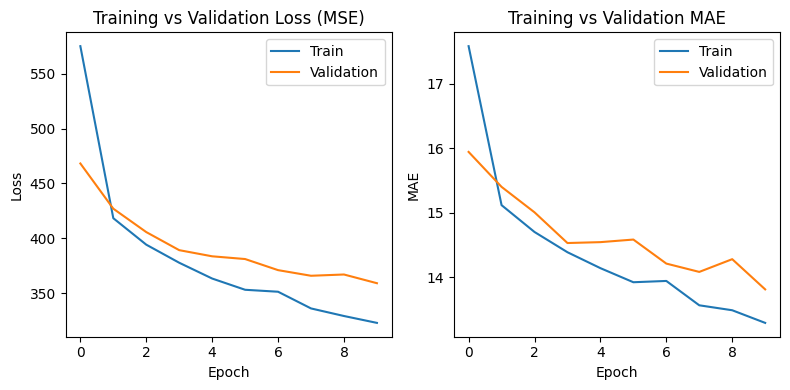

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Training vs Validation Loss (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.title("Training vs Validation MAE")
plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.legend()
plt.tight_layout()
plt.show()

## Evaluasi Model

MAE = 13.82
RMSE = 18.95
R2 = 0.188


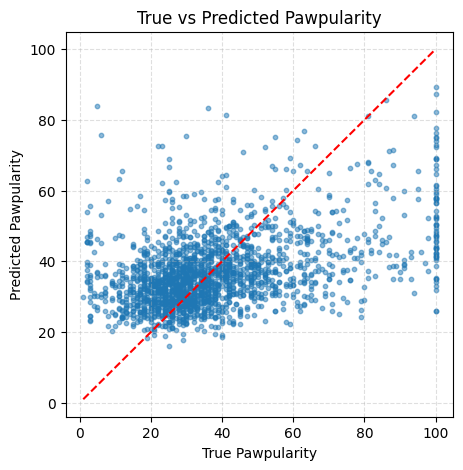

In [22]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in val_ds])
mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(np.mean((y_true - y_pred)**2))
r2 = r2_score(y_true, y_pred)
print(f"MAE = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R2 = {r2:.3f}")

# Plot hasil prediksi vs nilai sebenarnya:
plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, s=10, alpha=0.5)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("True Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("True vs Predicted Pawpularity")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

## Melihat Contoh Prediksi

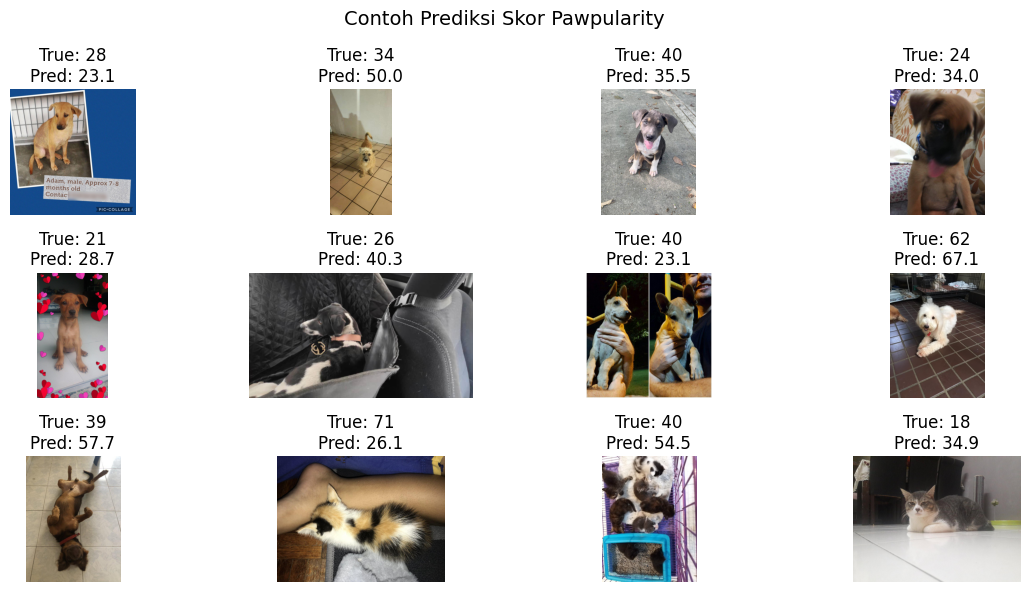

In [23]:
import random
from PIL import Image

sample_rows = val_df.sample(12, random_state=1)
plt.figure(figsize=(12,6))

for i, row in enumerate(sample_rows.itertuples()):
  img = Image.open(row.path)
  pred = model.predict(tf.expand_dims(load_image(row.path,
  row.Pawpularity)[0], 0), verbose=0).ravel()[0]
  plt.subplot(3,4,i+1)
  plt.imshow(img)
  plt.title(f"True: {row.Pawpularity}\nPred: {pred:.1f}")
  plt.axis('off')
plt.suptitle("Contoh Prediksi Skor Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()

Saving meong.jpeg to meong (1).jpeg


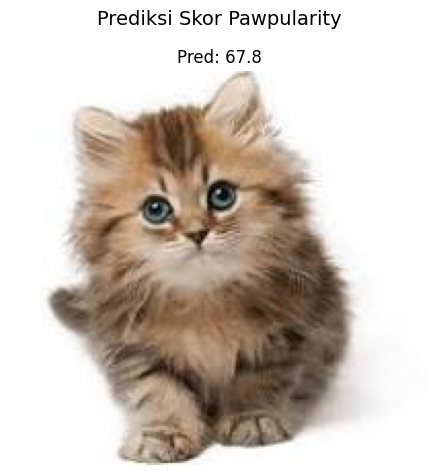

In [26]:
from google.colab import files
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import math

def load_image(path, label=None):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    return img, label

uploaded = files.upload()


for i, (filename, _) in enumerate(uploaded.items()):
    img_path = filename

    img_display = Image.open(img_path)

    img_tensor, _ = load_image(img_path)

    pred = model.predict(tf.expand_dims(img_tensor, 0), verbose=0).ravel()[0]

    plt.imshow(img_display)
    plt.title(f"Pred: {pred:.1f}")
    plt.axis("off")

plt.suptitle("Prediksi Skor Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()
